#**Sleep, Lifestyle, and Health of Professionals and Students Data Science**
Project by Team Sleeping On It: *Ishaan Adhikary, Aarav Gadkar, Justin Ma, Mohammed Umar*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations

from sklearn.base import clone

from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

from sklearn.neighbors import KNeighborsRegressor

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Data Preparation and Feature Engineering

## Importing Datasets
First, we import our three datasets.

In [2]:
url_stem = "https://raw.githubusercontent.com/gaminghusky1/DataScienceProject/main/"

In [3]:
stanford_df_raw = pd.read_csv(url_stem + "StanfordSleepSurvey.csv")
efficiency_df_raw = pd.read_csv(url_stem + "Sleep_Efficiency.csv")
lifestyle_df_raw = pd.read_csv(url_stem + "SleepHealthLifestyle.csv")

## Stanford Summer Session Survey Results

In [4]:
stanford_df_raw.head()

,Timestamp,Age,Sex,Class Units,Method of Transport,Quality of Sleep,Stress Level,Steps,Sleep Disorder,Mental Disorder,Notes
0,7/25/2024 11:47:39,16,Female,9,Bike,5,7,10000,NaN,NaN,NaN
1,7/25/2024 12:10:25,17,Male,14,Walk,4,10,"8,000",none,NaN,NaN
2,7/25/2024 12:11:00,22,Female,13,Walk,7,6,10000,NaN,Anxiety,NaN
3,7/25/2024 12:11:58,17,Male,10,Bike,6,8,20000,NaN,NaN,NaN
4,7/25/2024 12:14:15,17,Male,9,Drive,5,7,3500,NaN,NaN,NaN


First, we can drop the `Timestamp` and `Notes` sections, as they are not needed in our analysis.

In [5]:
stanford_df = stanford_df_raw[
    ['Age', 'Sex', 'Class Units','Method of Transport', 'Quality of Sleep',
     'Stress Level', 'Steps', 'Sleep Disorder', 'Mental Disorder']].copy()

Secondly, we should format the steps by dealing with the various extra characters that were typed by respondents in response to the steps question. Let's start by determining which extraneous characters we will have to deal with:

In [6]:
def strip_nums_from_string(input):
  input = str(input)
  final = ""
  for c in input:
    if not c.isdigit():
      final += c
  return final

stanford_df_raw['Steps'].apply(strip_nums_from_string).value_counts()

,count
Steps,
,14
nan,14
",",5
-,3
K,2
~k,1
~ walking miles excluding workouts,1
N/a,1
",-,",1


From this analysis we find that the characters we have to deal with are: `","; "-"; "K"; "k"; "~"`; and other text that signifies either that that responder did not track steps or measured in different units.

For each of these, we can derive the meaning intended through the general meaning of each symbol.

*   `,`: Generally, commas are used to seperate groups of three digits in numbers, and so we should be able to drop them.
*   `-`: Generally, dashes are used to signify ranges. We can take the average of values on both sides of the range to find a single estimated amount of steps.
*   `k/K`: This usually means $num*1000$, so we can replace `k`s with `000`.
*   `~`: Generally, tildas mean about. We can drop these to get our numerical estimation.
*   Finally, all other characters, like `N/a` and `walking miles...` mean that steps were not recorded or estimated by these respondees, so we can replace these entires with `nan` to signify there is no response.

Let's make these changes!


In [7]:
def make_steps_numbers(input):
  input = str(input)
  # If contains other characters, replace with no response
  for char in input:
    if char not in "~,kK-" and not char.isdigit():
      return np.nan

  # Strip ~ and ,
  for char in "~,":
    input = input.replace(char, '')
  # Replace k with 000
  for char in "kK":
    input = input.replace(char, "000")
  # Average values on both sides of -
  final = 0
  input = input.split('-')
  for val in input:
    final += int(val)

  return final

stanford_df['Steps'] = stanford_df_raw['Steps'].apply(make_steps_numbers)
stanford_df.head()

,Age,Sex,Class Units,Method of Transport,Quality of Sleep,Stress Level,Steps,Sleep Disorder,Mental Disorder
0,16,Female,9,Bike,5,7,10000.0,NaN,NaN
1,17,Male,14,Walk,4,10,8000.0,none,NaN
2,22,Female,13,Walk,7,6,10000.0,NaN,Anxiety
3,17,Male,10,Bike,6,8,20000.0,NaN,NaN
4,17,Male,9,Drive,5,7,3500.0,NaN,NaN


Thirdly, we should vectorize the specific sleep disorders and mental health disorders we want to analyze from the Sleep Disorder and Mental Disorder columns, respectively.

In [8]:
def extract_sleep_disorders(input):
  insomnia = 0
  apnea = 0
  input = str(input['Sleep Disorder']).lower()
  if "insomnia" in input:
    insomnia = 1
  if "apnea" in input:
    apnea = 1
  return [insomnia, apnea]

stanford_df[['Insomnia', 'Sleep Apnea']] = stanford_df_raw.apply(
    extract_sleep_disorders, axis = 'columns', result_type = 'expand')

In [9]:
stanford_df_raw['Mental Disorder'].unique()

array([nan, 'Anxiety ',
       "I think I might have a light case of anxiety. Recently my mood hasn't been the best. I keep overthinking things, and am not able to communicate my problems too well.",
       'none', 'Anxiety and depression',
       'N/A. I have some mild anxiety but I am getting better at working around it (:',
       'Bi- polar depression, generalized anxiety, obsessive compulsive disorder',
       'Anxiety, dpdr', 'Anxiety',
       'Obsessing over someone, missing her a lot after not seeing each other for a long time, thinking about it all the time. (Not sure it answers your question)',
       'Anxiety.', 'Non, im aware of'], dtype=object)

In [10]:
def extract_mental_disorders(input):
  anxiety = 0
  depression = 0
  ocd = 0
  dpdr = 0
  input = str(input['Mental Disorder']).lower()
  if "anxiety" in input:
    anxiety = 1
  if "depression" in input:
    depression = 1
  if "ocd" in input or "obsessive compulsive" in input:
    ocd = 1
  if "dpdr" in input or "depersonalization" in input or "derealization" in input:
    dpdr = 1
  return [anxiety, depression, ocd, dpdr]

stanford_df[['Anxiety', 'Depression', 'OCD', 'DPDR']] = stanford_df_raw.apply(extract_mental_disorders, axis = 'columns', result_type = 'expand')

In [11]:
stanford_df = stanford_df[
    ['Age', 'Sex', 'Class Units', 'Method of Transport','Quality of Sleep',
     'Stress Level', 'Steps', 'Insomnia', 'Sleep Apnea', 'Anxiety',
     'Depression', 'OCD', 'DPDR']]

In [12]:
stanford_df.head()

,Age,Sex,Class Units,Method of Transport,Quality of Sleep,Stress Level,Steps,Insomnia,Sleep Apnea,Anxiety,Depression,OCD,DPDR
0,16,Female,9,Bike,5,7,10000.0,0,0,0,0,0,0
1,17,Male,14,Walk,4,10,8000.0,0,0,0,0,0,0
2,22,Female,13,Walk,7,6,10000.0,0,0,1,0,0,0
3,17,Male,10,Bike,6,8,20000.0,0,0,0,0,0,0
4,17,Male,9,Drive,5,7,3500.0,0,0,0,0,0,0


## Sleep Efficiency Dataset

In [13]:
efficiency_df_raw.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


For this dataset, only three simple changes need to be made. The first is to set the index to the `ID`, as this is the most logical index for the dataset. The second is to remove the date information from `Bedtime` and `Wakeup time`, as each column represents the typical bedtime and wakeup time for each participant. The exact date on which the data was recorded does not matter for our purposes. Finally, we should rename `Gender` to `Sex` to better represent the meaning of the data and ensure consistency across dataframes.

In [14]:
def strip_date(input):
  bedtime = pd.Timestamp(input['Bedtime']).strftime('%X')
  wakeup = pd.Timestamp(input['Wakeup time']).strftime('%X')
  return [bedtime, wakeup]

efficiency_df = efficiency_df_raw.copy()
efficiency_df[['Bedtime', 'Wakeup time']] = efficiency_df_raw.apply(
    strip_date, axis = 'columns', result_type = 'expand')
efficiency_df = efficiency_df.set_index('ID').rename(
    {'Gender' : 'Sex'}, axis = 'columns')
efficiency_df.head()

,Age,Sex,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
ID,,,,,,,,,,,,,,
1,65,Female,01:00:00,07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
2,69,Male,02:00:00,09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
3,40,Female,21:30:00,05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
4,40,Female,02:30:00,08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
5,57,Male,01:00:00,09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


##Sleep and Lifestyle Dataset

In [15]:
lifestyle_df_raw.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


TFor this dataset we have to make a few changes. First is to set the index to `Person ID` and to rename the `Gender` column to `Sex`. We can also fill `NaN` values with `None` in the `Sleep Disorder` column.

In [16]:
lifestyle_df = lifestyle_df_raw.set_index('Person ID').rename(
    {'Gender' : 'Sex'}, axis = 'columns')
lifestyle_df["Sleep Disorder"] = lifestyle_df["Sleep Disorder"].fillna("None")
lifestyle_df

,Sex,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


Now, we can tackle the qualitative observations in the `Occupation` column. For our purposes, we can combine `Software Engineer` and `Engineer` into `Engineer` along with `Sales Representative` and `Salesperson` into `Sales`. For the `BMI Category`, `Normal` and `Normal Weight` are redundant categories that can be combined into `Normal.` Finally, we should split Blood Pressure into two seperate numerical values to represent the Stylostic and Diastolic measurements seperately.

In [17]:
print(lifestyle_df["Occupation"].unique())
print(lifestyle_df["BMI Category"].unique())
lifestyle_df["Blood Pressure"].head()

['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
['Overweight' 'Normal' 'Obese' 'Normal Weight']


,Blood Pressure
Person ID,
1,126/83
2,125/80
3,125/80
4,140/90
5,140/90


In [18]:
lifestyle_df["Sleep Disorder"] = lifestyle_df["Sleep Disorder"].fillna("None")
lifestyle_df["BMI Category"] = lifestyle_df["BMI Category"].replace("Normal Weight", "Normal")
lifestyle_df["Occupation"] = lifestyle_df["Occupation"].replace("Software Engineer", "Engineer")
lifestyle_df["Occupation"] = lifestyle_df["Occupation"].replace("Sales Representative", "Salesperson")
systolic = []
diastolic = []
for i in lifestyle_df["Blood Pressure"]:
  sys_dia_split = i.split('/')
  systolic.append(int(sys_dia_split[0]))
  diastolic.append(int(sys_dia_split[1]))
lifestyle_df["Systolic"] = pd.DataFrame(systolic)
lifestyle_df["Diastolic"] = pd.DataFrame(diastolic)
lifestyle_df

,Sex,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
Person ID,,,,,,,,,,,,,,
1,Male,27,Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None,125.0,80.0
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,125.0,80.0
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,140.0,90.0
4,Male,28,Salesperson,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140.0,90.0
5,Male,28,Salesperson,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea,140.0,95.0
370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea,140.0,95.0
371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea,140.0,95.0


#Dataset 3 EDA

<Axes: title={'center': 'Stanford Students Sleep Quality Distribution'}, xlabel='Quality of Sleep', ylabel='Count'>

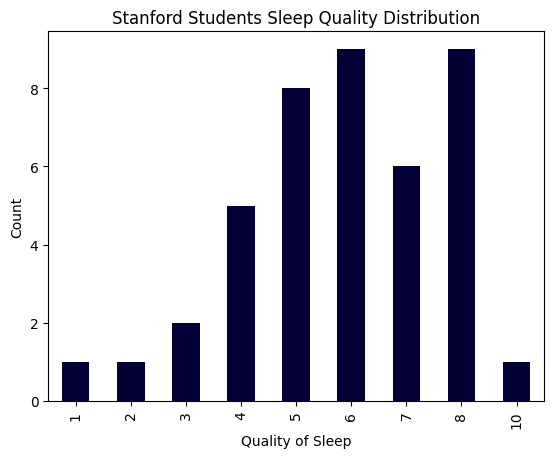

In [19]:
stanford_df['Quality of Sleep'].value_counts().sort_index().plot.bar(
    color='xkcd:midnight blue', ylabel='Count',
    title="Stanford Students Sleep Quality Distribution")

<Axes: title={'center': 'Ways Stanford Students get to Class'}, xlabel='Method of Transport', ylabel='Count'>

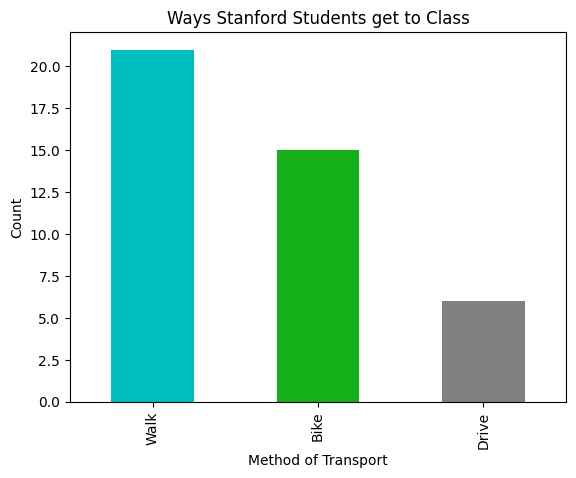

In [20]:
stanford_df['Method of Transport'].value_counts().plot.bar(ylabel='Count',
    color=['c', 'xkcd:green', 'gray'], title="Ways Stanford Students get to Class")

# Primary Questions

##Question 1
####What similarities emerge when student’s academic and lifestyle information are grouped together? What “types” of student lifestyles are observed? Are these types meaningful? What lifestyle patterns are most common among Stanford summer students?

In [21]:
stanf_clust_num_cols = ['Quality of Sleep', 'Stress Level', 'Steps']
stanford_df[stanf_clust_num_cols].head(3)

,Quality of Sleep,Stress Level,Steps
0,5,7,10000.0
1,4,10,8000.0
2,7,6,10000.0


In [22]:
stanf_clust_enc_cols = ['Method of Transport']
stanford_df[stanf_clust_enc_cols].head(3)

,Method of Transport
0,Bike
1,Walk
2,Walk


In [23]:
transformer = make_column_transformer(
    (StandardScaler(), stanf_clust_num_cols),
    (OneHotEncoder(), stanf_clust_enc_cols),
    remainder='drop'
)

stanford_clust_df = pd.DataFrame(transformer.fit_transform(stanford_df)).dropna()

In [24]:
stanford_clust_df.corr()

,0,1,2,3,4,5
0,1.000000,-0.133054,0.178318,0.160139,-0.110651,-0.048298
1,-0.133054,1.000000,-0.187099,0.252336,-0.247279,-0.017933
2,0.178318,-0.187099,1.000000,-0.209033,-0.239076,0.368981
3,0.160139,0.252336,-0.209033,1.000000,-0.267261,-0.639602
4,-0.110651,-0.247279,-0.239076,-0.267261,1.000000,-0.569803
5,-0.048298,-0.017933,0.368981,-0.639602,-0.569803,1.000000


The only columns used in the analysis with high correlation to each other are the one hot encoder results to themselves, which is irrelevant for this problem. These independent variables are able to be used in the model.

First, we construct a clustering model with KMeans(), searching for the best value for K.

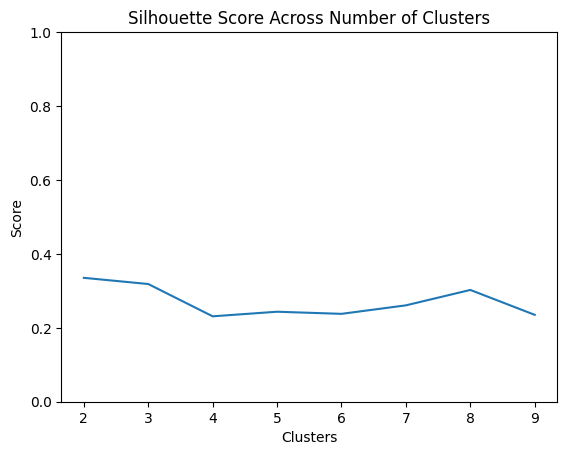

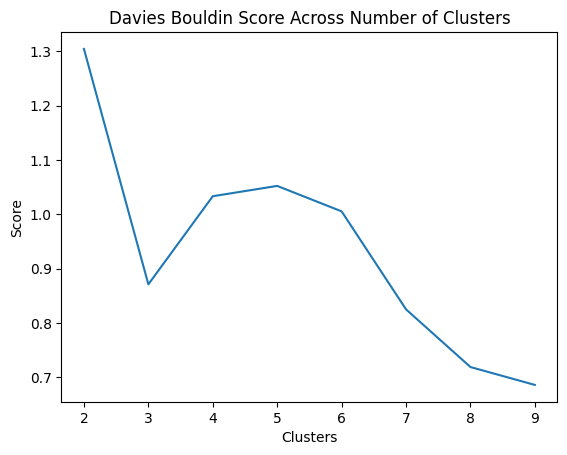

In [25]:
sil_scores = {}
db_scores = {}
models = {}

for i in range(2, 10):
  models[i] = KMeans(n_clusters=i, init='random', n_init=10, random_state=9819)

  models[i].fit(stanford_clust_df)
  sil_scores[i] = silhouette_score(stanford_clust_df, models[i].labels_)
  db_scores[i] = davies_bouldin_score(stanford_clust_df, models[i].labels_)

scores = pd.DataFrame({"Silhouette" : sil_scores, "Davies Bouldin" : db_scores})

plt.figure()
plt.title("Silhouette Score Across Number of Clusters")
plt.plot(scores.index, scores['Silhouette'])
plt.xlabel("Clusters")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.title("Davies Bouldin Score Across Number of Clusters")
plt.plot(scores.index, scores['Davies Bouldin'])
plt.xlabel("Clusters")
plt.ylabel("Score")
plt.show()

Model 3 is the best value of k.

In [26]:
model = models[3]

display(pd.Series(model.labels_).value_counts())
for label in pd.Series(model.labels_).unique():
  print("Sleep Quality Information in Cluster " + str(label))
  print(stanford_clust_df[model.labels_ == label][0].describe())

  print("Stress Information in Cluster " + str(label))
  print(stanford_clust_df[model.labels_ == label][1].describe())

  print("Steps Activity Information in Cluster " + str(label))
  print(stanford_clust_df[model.labels_ == label][2].describe())

  print("Transport Method Information in Cluster " + str(label))
  print(pd.DataFrame(
      stanford_clust_df[model.labels_ == label].iloc[:, 3:6].sum()).T.rename(
          {3 : "Walk", 4 : "Drive", 5 : "Bike"}, axis=1))
  print()

,count
0,19
1,6
2,1


Sleep Quality Information in Cluster 0
count    19.000000
mean     -0.134488
std       0.954813
min      -2.632319
25%      -0.475101
50%      -0.475101
75%       0.603507
max       1.142812
Name: 0, dtype: float64
Stress Information in Cluster 0
count    19.000000
mean      0.567989
std       0.600568
min      -0.211604
25%       0.282138
50%       0.282138
75%       0.775880
max       2.257106
Name: 1, dtype: float64
Steps Activity Information in Cluster 0
count    19.000000
mean     -0.312813
std       0.426924
min      -1.007872
25%      -0.550892
50%      -0.297014
75%      -0.193228
max       0.718498
Name: 2, dtype: float64
Transport Method Information in Cluster 0
   Walk  Drive  Bike
0   6.0    3.0  10.0

Sleep Quality Information in Cluster 1
count    6.000000
mean     0.064203
std      1.131254
min     -2.093014
25%      0.064203
50%      0.333855
75%      0.603507
max      1.142812
Name: 0, dtype: float64
Stress Information in Cluster 1
count    6.000000
mean    -1.610539
s

###Evaluation
Overall, the clusters that form from this set of collected data are slightly weaker than a reasonable set of clusters as the `Silhouette Score` indicates an existing but slightly weak relationship while the `Davies Bouldin Index` also indicates an existing but slightly weak relationship among clusters, even in the case of the best cluster grouping when three clusters were used. As a result, care should be taken not to extrapolate crucial information from this analysis. One example of the weakness of this data is in cluster two, which only consists of a single student. This means that specific student is an **anomaly** or an **outlier** in the data, likely as their step count is incredibly high compared to the rest of the group; they have about `4.27` after standardization while the next runner-up only has `1.14`. Another signifier of the weakness of the clusters is the high standard deviation among categories within each cluster. For most features, the standard deviation is higher than the mean, indicating a large possible range of values within each cluster and weakening the apparent groupings.

Despite this clustering weakness, the remaining clusters do still show a few compelling trends. Mainly, sleep quality, stress, and step count do differ significantly from group to group. The biggest factor in groupings was stress level, which signifies the the biggest two categories of Stanford lifestyles are based on the amount of stress a student will face. The split between stressed students and less stressed students is heavily in favor of the stressed students, who make up 19 of the 26 students included. Students belonging to the less stressed group tended to take more steps in a day and get slightly better sleep. Meanwhile, the more stressed group got slightly worse sleep and on average took less steps in a day. This indicates that sleep and stress are related; if a health official or professor was looking to encourage more students to join the low-stress cluster, suggesting healthier sleep habits like encouraged in the many other analyses above would likely result in a student body with less stress overall.

##Question 2
#### Can a student’s quality of sleep be predicted using information about their lifestyle and classes? What information about a student has the greatest impact on the prediction, and how can these results be interpreted?

In [27]:
# Only include prescence columns that have more than 1 person in our regression
# model
display(pd.DataFrame(stanford_df.loc[:, 'Insomnia':'DPDR'].sum() > 1).T)

df_stanf_poss = stanford_df[['Sex', 'Class Units', 'Method of Transport',
                            'Stress Level', 'Anxiety', 'Depression']].copy()

df_stanf_poss['Sex'] = df_stanf_poss['Sex'].map({
    'Female' : 1,
    'Male' : 0
})

df_stanf_y = stanford_df['Quality of Sleep']

df_stanf_poss.head(3)

,Insomnia,Sleep Apnea,Anxiety,Depression,OCD,DPDR
0,False,False,True,True,False,False


,Sex,Class Units,Method of Transport,Stress Level,Anxiety,Depression
0,1,9,Bike,7,0,0
1,0,14,Walk,10,0,0
2,1,13,Walk,6,1,0


In [28]:
combo_lin_scores = {}
combo_lin_models = {}

for amt_in_combo in range(1, df_stanf_poss.shape[0]):
  for combo in combinations(df_stanf_poss.columns, amt_in_combo):
    stanf_transformer = make_column_transformer(
      (StandardScaler(),
       list(set(['Sex', 'Class Units', 'Stress Level',
                 'Anxiety', 'Depression']) & set(combo))),
      (OneHotEncoder(),
       list(set(['Method of Transport']) & set(combo))),
      remainder='passthrough'
    )

    combo_lin_pipeline = make_pipeline(
        stanf_transformer,
        LinearRegression()
    )

    combo_lin_models[combo] = clone(combo_lin_pipeline)
    combo_lin_scores[combo] = -cross_val_score(
        combo_lin_pipeline,
        X=df_stanf_poss[list(combo)],
        y=df_stanf_y,
        scoring='neg_root_mean_squared_error',
        cv=4).mean()

In [29]:
(min(combo_lin_scores, key=combo_lin_scores.get),
 combo_lin_scores[min(combo_lin_scores, key=combo_lin_scores.get)])

(('Sex', 'Stress Level'), 1.7935656844595282)

In [30]:
combo_knn_scores = {}
combo_knn_models = {}

for amt_in_combo in range(1, df_stanf_poss.shape[0]):
  for combo in combinations(df_stanf_poss.columns, amt_in_combo):
    stanf_transformer = make_column_transformer(
      (StandardScaler(),
       list(set(['Sex', 'Class Units', 'Stress Level',
                 'Anxiety', 'Depression']) & set(combo))),
      (OneHotEncoder(), list(set(['Method of Transport']) & set(combo))),
      remainder='drop'
    )
    combo_knn_pipeline = make_pipeline(
        stanf_transformer,
        KNeighborsRegressor()
    )
    stanf_knn_gridcv = GridSearchCV(
        combo_knn_pipeline,
        {"kneighborsregressor__n_neighbors" : range(1, 7),
         "kneighborsregressor__metric" : ['euclidean', 'manhattan']},
        scoring='neg_root_mean_squared_error',
        cv=4
    )
    stanf_knn_gridcv.fit(df_stanf_poss[list(combo)], df_stanf_y)

    combo_knn_models[combo] = clone(stanf_knn_gridcv.best_estimator_)
    combo_knn_scores[combo] = -stanf_knn_gridcv.best_score_

In [31]:
(min(combo_knn_scores, key=combo_knn_scores.get),
 combo_knn_scores[min(combo_knn_scores, key=combo_knn_scores.get)],
 combo_knn_models[
     min(combo_knn_scores, key=combo_knn_scores.get)]['kneighborsregressor'])

(('Sex', 'Method of Transport', 'Stress Level', 'Anxiety'),
 1.8145670558095324,
 KNeighborsRegressor(metric='euclidean', n_neighbors=4))

Now that we've selected our models, let's compare them with a train-test split:

In [32]:
best_knn_combo = min(combo_knn_scores, key=combo_knn_scores.get)
best_knn_model = combo_knn_models[best_knn_combo]
best_lin_combo = min(combo_lin_scores, key=combo_lin_scores.get)
best_lin_model = combo_lin_models[best_lin_combo]

X_train, X_test, y_train, y_test = train_test_split(
    df_stanf_poss, df_stanf_y, test_size=0.5, random_state = 3383)

best_lin_model.fit(X_train[list(best_lin_combo)], y_train)
best_knn_model.fit(X_train[list(best_knn_combo)], y_train)
lin_pred = best_lin_model.predict(X_test)
knn_pred = best_knn_model.predict(X_test)

print("Model RMSEs:")
print("Linear Regression: " + str(mean_squared_error(y_test, lin_pred)))
print("KNN: " + str(mean_squared_error(y_test, knn_pred)))
print("Simple Mean (for Comparison): " + str(
    mean_squared_error(y_test, [y_test.mean()] * y_test.count())))

Model RMSEs:
Linear Regression: 4.248084414029904
KNN: 4.377976190476191
Simple Mean (for Comparison): 4.2358276643990935


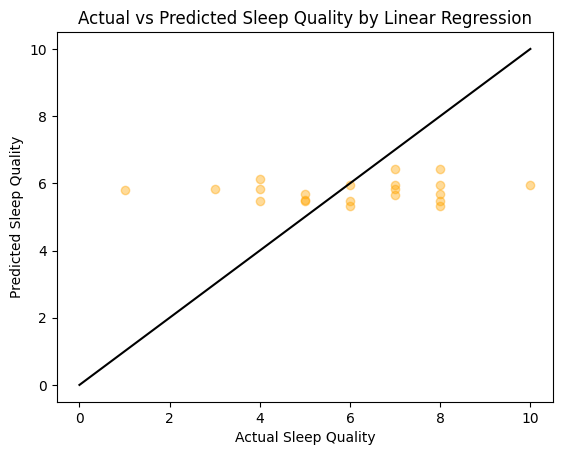

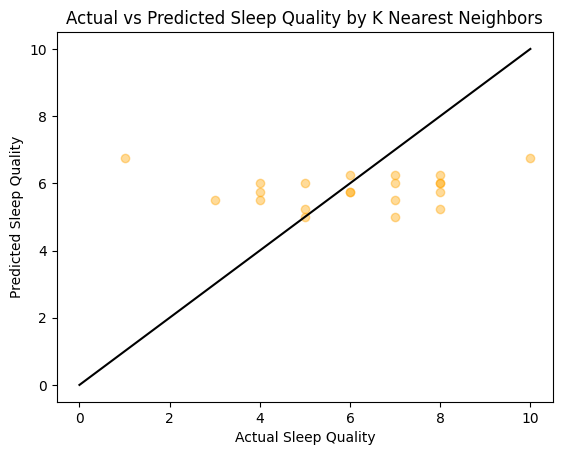

In [33]:
plt.plot([0, 10], [0, 10], c='black')
plt.scatter(x=y_test, y=lin_pred, alpha=0.4, c='orange')
plt.title("Actual vs Predicted Sleep Quality by Linear Regression")
plt.xlabel("Actual Sleep Quality")
plt.ylabel("Predicted Sleep Quality")
plt.show()

plt.plot([0, 10], [0, 10], c='black')
plt.scatter(x=y_test, y=knn_pred, alpha=0.4, c='orange')
plt.title("Actual vs Predicted Sleep Quality by K Nearest Neighbors")
plt.xlabel("Actual Sleep Quality")
plt.ylabel("Predicted Sleep Quality")
plt.show()

From these visualizations, it is clear that the predictors are not reliant on their independent variables to make predictions. In the K Nearest Neighbors model, it is clear that the neighbors of each test case student are typically representative of the mean of the entire dataset, meaning that the data is generally centered around the mean. Interestingly, this pattern does not apply at the extremes of sleep quality, which appear to have more in common with each other than more moderate ratings.

In the linear model, all of the coefficients are close to zero. This indicates that there is not much variation in the model across variable values, which signifies that the searched features are generally poor predictors of sleep quality.

Ultimately, the Stanford dataset suffers from being short and lacking data overall, along with a poor selection of features. Future datasets should be constructed to be more comprehensive and to range from a wide array of sources.
